In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from branca.colormap import LinearColormap
import statistics
import numpy as np
from pymongo import MongoClient
from geopy.distance import geodesic
from pymongo import DESCENDING
import pandas as pd
import pymongo

In [11]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [43]:
class MongoDBConnector:
    """
    A class to connect to MongoDB and perform various queries.

    Attributes:
        host (str): The MongoDB server host address.
        port (int): The MongoDB server port number.
        db_name (str): The name of the MongoDB database.
        client: The MongoClient object for connecting to MongoDB.
        db: The MongoDB database object.
    """

    def __init__(self, host='localhost', port=27017, db_name='restaurant', collection_name='restaurants'):
        """
        Initialize the MongoDBConnector object with host, port, and database name.

        Args:
            host (str): The MongoDB server host address.
            port (int): The MongoDB server port number.
            db_name (str): The name of the MongoDB database.
        """
        self.client = MongoClient(host, port)
        self.db = self.client[db_name]
        self.collection = self.db[collection_name]

    def find_restaurants_by_cuisine(self, cuisine):
        """
        Find restaurants by cuisine.

        Args:
            cuisine (str): The cuisine type to search for.

        Returns:
            pymongo.cursor.Cursor: A cursor to iterate over the matching restaurants.
        """
        return self.collection.find({'cuisine': cuisine})

    def find_restaurants_by_borough(self, borough):
        """
        Find restaurants by borough.

        Args:
            borough (str): The borough name to search for.

        Returns:
            pymongo.cursor.Cursor: A cursor to iterate over the matching restaurants.
        """
        return self.collection.find({'borough': borough})

    def find_restaurants_by_name(self, name):
        """
        Find restaurants by name (supports partial matches and case-insensitive search).

        Args:
            name (str): The name (or part of the name) of the restaurant to search for.

        Returns:
            pymongo.cursor.Cursor: A cursor to iterate over the matching restaurants.
        """
        return self.collection.find({'name': {'$regex': name, '$options': 'i'}})

    def plot_top_cuisines(self, borough):
        """
        Plot the top rated cuisines in a given borough.

        Parameters:
        - borough: The borough for which to plot the top rated cuisines.
        """
        pipeline = [
            {
                '$match': {'borough': borough}
            },
            {
                '$unwind': {
                    'path': '$grades',
                    'includeArrayIndex': 'ratings',
                    'preserveNullAndEmptyArrays': True
                }
            },
            {
                '$group': {
                    '_id': '$cuisine',
                    'avgrating': {'$avg': '$grades.score'}
                }
            },
            {
                '$sort': {'avgrating': -1}
            },
            {
                '$limit': 5
            }
        ]

        result = list(self.collection.aggregate(pipeline))

        if not result:
            print(f"No data found for the borough '{borough}'.")
            return

        cuisines = [entry['_id'] for entry in result]
        ratings = [entry['avgrating'] for entry in result]

        # Print the top cuisines and their ratings
        print("Top Rated Cuisines in", borough)
        for cuisine, rating in zip(cuisines, ratings):
            print(f"Cuisine: {cuisine}, Average Rating: {rating}")

        # Plotting
        sns.set(style="whitegrid")
        plt.figure(figsize=(10, 6))
        sns.barplot(x=ratings, y=cuisines, palette="viridis")
        plt.title(f"Top Rated Cuisines in {borough}")
        plt.xlabel("Average Rating")
        plt.ylabel("Cuisine")
        plt.show()

    def find_biggest_competitor(self, restaurant_name):
        """
        Find the closest competitor to a given restaurant.

        Parameters:
        - restaurant_name: The name of the restaurant to find competitors for.

        Returns:
        - A dictionary containing information about the closest competitor, or None if no competitor is found.
        """
        restaurant = self.collection.find_one({'name': restaurant_name})
        if restaurant:
            cuisine = restaurant.get('cuisine')
            longitude, latitude = restaurant.get('address', {}).get('coord', [0, 0])
            competitors = self.collection.find({'cuisine': cuisine, 'name': {'$ne': restaurant_name}})
            closest_distance = float('inf')
            closest_restaurant = None
            for comp_restaurant in competitors:
                comp_longitude, comp_latitude = comp_restaurant.get('address', {}).get('coord', [0, 0])
                distance = geodesic((latitude, longitude), (comp_latitude, comp_longitude)).kilometers
                if distance < closest_distance:
                    closest_distance = distance
                    closest_restaurant = comp_restaurant
            if closest_restaurant:
                return {
                    'name': closest_restaurant.get('name'),
                    'cuisine': closest_restaurant.get('cuisine'),
                    'street': closest_restaurant.get('address', {}).get('street'),
                    'borough': closest_restaurant.get('borough'),
                    'latitude': closest_restaurant.get('address', {}).get('coord')[1],
                    'longitude': closest_restaurant.get('address', {}).get('coord')[0]
                }
            else:
                return None
        else:
            return None
    
    def plot_restaurants(self, borough, cuisine):
        """
        Plot the restaurants in a given borough serving a specific cuisine.

        Parameters:
        - borough: The borough to search for restaurants.
        - cuisine: The cuisine to filter restaurants.
        """
        # Initialize the map with a title based on the borough and cuisine
        map_title = f"<b>Top Rated {cuisine.capitalize()} Restaurants in {borough.capitalize()}</b>"
        m = folium.Map(location=[40.7128, -74.0060], zoom_start=10)
        folium.Marker(location=[40.7128, -74.0060], popup=map_title, icon=folium.Icon(color='blue')).add_to(m)
        # Query restaurants based on borough and cuisine
        restaurants = self.collection.find({'borough': borough, 'cuisine': cuisine})
        
        # Calculate average rating for each restaurant and store it along with other information
        restaurant_info = []
        for idx, restaurant in enumerate(restaurants, start=1):
            name = restaurant['name']
            street = restaurant['address']['street']
            longitude, latitude = restaurant['address']['coord']
            
            grades = restaurant.get('grades', [])
            if grades:
                ratings = [grade['score'] for grade in grades if 'score' in grade]
                average_rating = sum(ratings) / len(ratings)
            else:
                average_rating = 0
            
            # Store restaurant information along with average rating
            restaurant_info.append({
                'name': name,
                'street': street,
                'latitude': latitude,
                'longitude': longitude,
                'average_rating': average_rating
            })
        
        # Sort restaurants based on their average ratings
        restaurant_info.sort(key=lambda x: x['average_rating'])
        # Print information for the top 15 restaurants
        print("Top 15 Restaurants:")
        for idx, restaurant in enumerate(restaurant_info[:15], start=1):
            name = restaurant['name']
            street = restaurant['street']
            latitude = restaurant['latitude']
            longitude = restaurant['longitude']
            print(f"Restaurant #{idx}:")
            print(f"   Name: {name}")
            print(f"   Street: {street}")
            print(f"   Latitude: {latitude}")
            print(f"   Longitude: {longitude}")
            print()
        
        # Divide the sorted restaurants into thirds
        num_restaurants = len(restaurant_info)
        third = num_restaurants // 3
        bottom_third = restaurant_info[:third]
        middle_third = restaurant_info[third:2*third]
        top_third = restaurant_info[2*third:]
        
        
        
        # Add markers for the bottom third (red icons)
        for restaurant in bottom_third:
            name = restaurant['name']
            street = restaurant['street']
            latitude = restaurant['latitude']
            longitude = restaurant['longitude']
            popup_text = f"<b>Name:</b> {name}<br><b>Street:</b> {street}<br><b>Average Rating:</b> {restaurant['average_rating']:.2f}"
            folium.Marker([latitude, longitude], popup=popup_text, tooltip=name, icon=folium.Icon(color='darkred')).add_to(m)
        
        # Add markers for the middle third (yellow icons)
        for restaurant in middle_third:
            name = restaurant['name']
            street = restaurant['street']
            latitude = restaurant['latitude']
            longitude = restaurant['longitude']
            popup_text = f"<b>Name:</b> {name}<br><b>Street:</b> {street}<br><b>Average Rating:</b> {restaurant['average_rating']:.2f}"
            folium.Marker([latitude, longitude], popup=popup_text, tooltip=name, icon=folium.Icon(color='beige')).add_to(m)
        
        # Add markers for the top third (green icons)
        for restaurant in top_third:
            name = restaurant['name']
            street = restaurant['street']
            latitude = restaurant['latitude']
            longitude = restaurant['longitude']
            popup_text = f"<b>Name:</b> {name}<br><b>Street:</b> {street}<br><b>Average Rating:</b> {restaurant['average_rating']:.2f}"
            folium.Marker([latitude, longitude], popup=popup_text, tooltip=name, icon=folium.Icon(color='green')).add_to(m)
        
        # Display the map inline
        display(m)

    def find_best_staten_island_restaurants(self):
        """
        Find the five restaurants in Staten Island with the most recent A grades.

        Parameters:
        - grades: letter grades given to each restaurant and the date the grade was given 
        - borough: borough of selection
        """
        # Define the pipeline
        pipeline = [
            {
                "$match": {
                    "grades.0.grade": "A",
                    "borough": "Staten Island"
                }
            },
            {
                "$sort": {
                    "grades.date": pymongo.ASCENDING
                }
            },
            {
                "$limit": 5
            }
        ]

        # Execute the aggregation pipeline
        results = self.collection.aggregate(pipeline)

        # Create a list to store the results
        restaurants_list = []

        # Iterate over the results and add them to the list
        for restaurant in results:
            restaurants_list.append({
                "name": restaurant["name"],
                "cuisine": restaurant["cuisine"],
                "borough": restaurant["borough"],
                "restaurant_id": restaurant["restaurant_id"]
            })

        # Return the list of restaurants
        return restaurants_list

    def plot_best_rated_cuisine_distribution(self):
        """
        Plot the distribution of different cuisines among the 100 NYC restaurants with the most recent score greater than or equal to 60.

        Returns:
        - A pie chart showing the distribution of cuisines.
        """
        # Define the aggregation pipeline
        pipeline = [
            {
                "$match": {
                    "grades.0.score": {"$gte": 60}
                }
            },
            {
                "$sort": {
                    "grades.date": pymongo.ASCENDING
                }
            },
            {
                "$limit": 100
            },
            {
                "$project": {
                    "cuisine": 1,
                    "restaurant_id": 1
                }
            }
        ]

        # Execute the aggregation pipeline
        results = list(self.collection.aggregate(pipeline))

        # Create a DataFrame from the results
        df = pd.DataFrame(results)

        # Count the number of restaurants in each cuisine, grouped by cuisine
        cuisine_counts = df[['cuisine', 'restaurant_id']].groupby('cuisine').count()

        # Create a pie chart of the cuisine counts
        plt.figure(figsize=(10, 6))
        cuisine_counts.plot(kind='pie', y='restaurant_id', autopct='%1.1f%%', legend=False)
        plt.title('Distribution of Different Cuisines Among the 100 Highly Rated NYC Restaurants')
        plt.ylabel('')
        plt.show()

    def find_brooklyn_american_restaurants(self):
        """
        Find Brooklyn restaurants with American cuisine and their average scores.

        Returns:
        - A list of dictionaries containing information about the restaurants.
        """
        # Define the aggregation pipeline
        pipeline = [
            # Match restaurants in Brooklyn with American cuisine
            {"$match": {"borough": "Brooklyn", "cuisine": "American"}},
            # Unwind the grades array to access individual grades
            {"$unwind": "$grades"},
            # Group by restaurant to calculate the average score
            {"$group": {
                "_id": "$_id",
                "name": {"$first": "$name"},
                "borough": {"$first": "$borough"},
                "cuisine": {"$first": "$cuisine"},
                "average_score": {"$avg": "$grades.score"}
            }},
            # Limit the number of results to 10
            {"$limit": 10},
            # Sort the results by average score in descending order
            {"$sort": {"average_score": pymongo.DESCENDING}},
            # Project only the necessary fields
            {"$project": {
                "name": 1,
                "borough": 1,
                "cuisine": 1,
                "average_score": 1,
                "_id": 0
            }}
        ]

        # Execute the aggregation pipeline and convert the result to a list
        result = list(self.collection.aggregate(pipeline))
        for restaurant in result:
            print("{name} ({cuisine}), {borough}, Average Score: {average_score}".format(
            name=restaurant["name"],
            cuisine=restaurant["cuisine"],
            borough=restaurant["borough"],
            average_score=restaurant["average_score"]
        ))
    
        # Create a DataFrame from the list of dictionaries
        df = pd.DataFrame(result)

        # Set the index to the restaurant names
        df.set_index('name', inplace=True)

        # Find the maximum and minimum average scores
        max_score = df['average_score'].max()
        min_score = df['average_score'].min()

        # Create a list of colors for the bars
        colors = ['red' if score == max_score else 'blue' if score == min_score else 'yellow' for score in df['average_score']]

        # Plot the bar graph with different colors for the tallest and shortest bars
        df.plot(kind='bar', y='average_score', color=colors, legend=False)
        plt.xlabel('Restaurant Name (Highest and Lowest Identified)')
        plt.ylabel('Average Score')
        plt.title('Average Scores of Restaurants in Brooklyn with American Cuisine')
        plt.show()
        return result
    
    
    def num_french_restaurants_in_each_borough(self):    
        match_french_cuisine = {'$match': {'cuisine': 'French'}}
        group_by_borough = {'$group': {'_id': '$borough', 'num':{'$sum': 1 }}}
        sort = {'$sort': {'num':1}}
        result = list(self.collection.aggregate([match_french_cuisine, group_by_borough, sort]))
        df = pd.DataFrame(result)
        ax = df.plot.bar(x='_id', y='num')
        ax.set_xlabel("Borough")
        ax.set_ylabel("Number")
        return result 
    
    
    def geonear_empire_state_building(self):
        # Create a 2dsphere index on the address.coord field
        self.collection.create_index([('address.coord', '2dsphere')])

        # Define the aggregation pipeline
        pipeline = [
            {
                "$geoNear": {
                    "near": {
                        "type": "Point",
                        "coordinates": [-73.985428, 40.748817]
                    },
                    "distanceField": "distance",
                    "maxDistance": 5000,
                    "spherical": True
                }
            },
            { "$limit": 10 }
        ]

        # Execute the aggregation pipeline
        result = list(self.collection.aggregate(pipeline))

        # Print the name of the restaurant, its distance from the given coordinates, and its address
        for doc in result:
            print(f"Name: {doc['name']}")
            print(f"Distance: {doc['distance']}")
            print(f"Address: {doc['address']['street']}, {doc['address']['building']}, {doc['address']['zipcode']}")
            print()
        return result
    
    def expensive_restaurants(self):
        result = list(self.collection.find({'address.zipcode' : '10013'}))
        df = pd.DataFrame(result)
        ax = df['cuisine'].value_counts().plot(kind='bar',
                                            figsize=(14,8),
                                            title="Cuisine type for the most expensive zipcode in New York")
        ax.set_xlabel("Cuisine")
        ax.set_ylabel("Number")


## Qustion: What are the top rated cuisines in a certain borough? 

Can give you promident cuisines to try in each borough, may give insights on ethnic and socioeconomic diversity throughout the boroughs. For example, in Queens we see no European cuisines make the list, with prominent cuisines from the global south and African-American cuisine. 

Top Rated Cuisines in Queens
Cuisine: Moroccan, Average Rating: 17.454545454545453
Cuisine: Bangladeshi, Average Rating: 15.413333333333334
Cuisine: Pakistani, Average Rating: 15.0
Cuisine: Creole, Average Rating: 14.85
Cuisine: Barbecue, Average Rating: 14.7


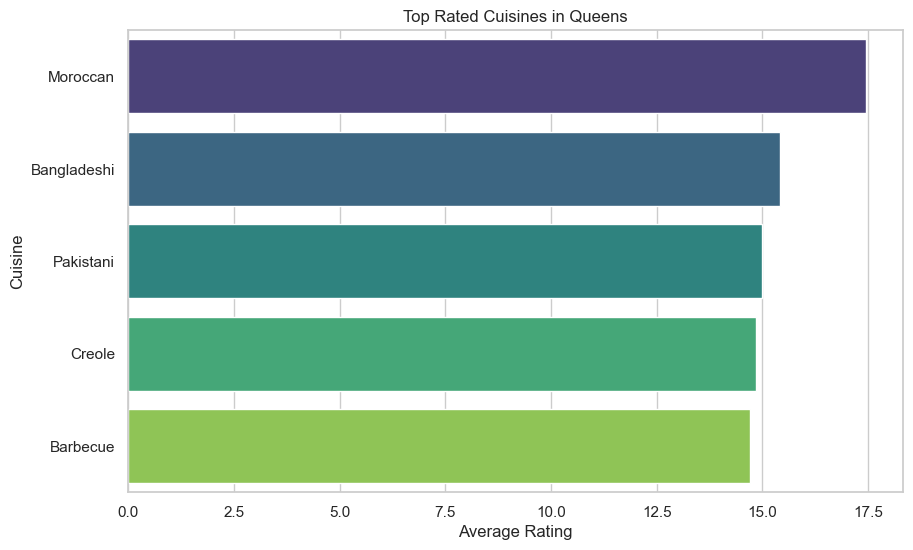

In [44]:
analyzer = MongoDBConnector()
analyzer.plot_top_cuisines('Queens')

## Question: Where are the restaurants that serve this cuisine in this borough?
Helps user visibly navigate through different dining options, can help find similar restaurants in the area, so the user can make their best decision.



In [45]:
analyzer.plot_restaurants('Queens', 'Italian')

Top 15 Restaurants:
Restaurant #1:
   Name: Romeo'S Pizza And Pasta
   Street: Liberty Avenue
   Latitude: 40.6817591
   Longitude: -73.83702860000001

Restaurant #2:
   Name: Fresco Deli & Kitchen
   Street: Fresh Pond Road
   Latitude: 40.707937
   Longitude: -73.89733199999999

Restaurant #3:
   Name: Villa Italian Kitchen
   Street: Laguardia Airport
   Latitude: 40.7766392
   Longitude: -73.87425

Restaurant #4:
   Name: Linizio Pizzeria
   Street: Vernon Boulevard
   Latitude: 40.744898
   Longitude: -73.953019

Restaurant #5:
   Name: Cucino A Modo Mio
   Street: 108 Street
   Latitude: 40.7438689
   Longitude: -73.85489299999999

Restaurant #6:
   Name: Tufino Pizzeria Napoletana
   Street: Ditmars Boulevard
   Latitude: 40.7741048
   Longitude: -73.90804589999999

Restaurant #7:
   Name: Genaro'S Pizzeria And Restaurant
   Street: College Point Boulevard
   Latitude: 40.7828357
   Longitude: -73.846121

Restaurant #8:
   Name: Vite-Vinosteria
   Street: 34 Street
   Latitude: 

## Question: Find this restaurant’s biggest competitor?

Pinpoints a restaurant's biggest competition.The User can decide to stay loyal or check out the competitor to decide who’s best overall!


In [46]:
analyzer.find_biggest_competitor(restaurant_name="Napoli Pizza")

{'name': 'Acquista Trattoria',
 'cuisine': 'Italian',
 'street': 'Union Turnpike',
 'borough': 'Queens',
 'latitude': 40.7266661,
 'longitude': -73.7899217}

## Question: What's an example of five Staten Island restaurants which were recently graded an A?

In [47]:
analyzer = MongoDBConnector()
restaurants = analyzer.find_best_staten_island_restaurants()
for restaurant in restaurants:
    print(restaurant)

{'name': "Giovanni'S Restaurant & Cafe", 'cuisine': 'Italian', 'borough': 'Staten Island', 'restaurant_id': '40641408'}
{'name': "Henny'S Restaurant", 'cuisine': 'American', 'borough': 'Staten Island', 'restaurant_id': '40398948'}
{'name': 'La Strada Restaurant', 'cuisine': 'Italian', 'borough': 'Staten Island', 'restaurant_id': '40391857'}
{'name': 'La Piazza Pizzeria & Restaurant', 'cuisine': 'Pizza', 'borough': 'Staten Island', 'restaurant_id': '40791157'}
{'name': "Sweet Sweet Sue'S", 'cuisine': 'American', 'borough': 'Staten Island', 'restaurant_id': '41477498'}


## Question: Of a sample of 100 New York City restaurants which were very highly scored recently, what is the distribution of different cuisine?

<Figure size 1000x600 with 0 Axes>

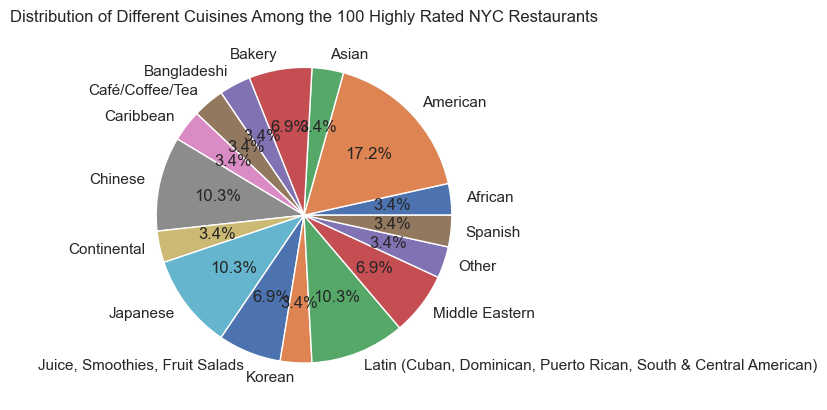

In [48]:
analyzer = MongoDBConnector()
analyzer.plot_best_rated_cuisine_distribution()

## Question: What are the ranges of scores given to American style restaurants in Brooklyn during early times of restaurant scoring? What's a highly scored restaurant and what's a low score restaurant, and how different are they?

Five Star Fish & Chips (American), Brooklyn, Average Score: 31.0
The Levee (American), Brooklyn, Average Score: 21.0
Papa'S Fried Chicken & Ice Cream (American), Brooklyn, Average Score: 13.0
Coco 66 (American), Brooklyn, Average Score: 12.0
C.M. Coffee Shop (American), Brooklyn, Average Score: 11.25
La Slowteria (American), Brooklyn, Average Score: 11.25
Mills Tavern (American), Brooklyn, Average Score: 10.5
New Shama Restaurant (American), Brooklyn, Average Score: 10.0
Harefield Road Pub (American), Brooklyn, Average Score: 8.0
Concession # 110 (American), Brooklyn, Average Score: 6.333333333333333


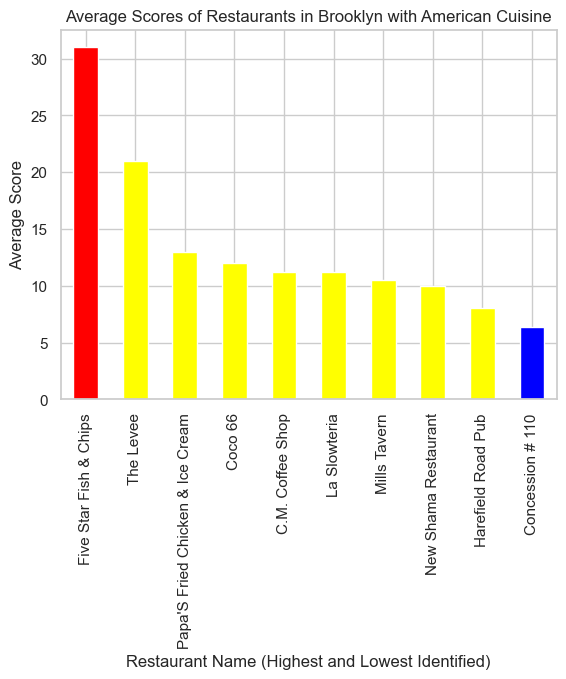

In [49]:
analyzer = MongoDBConnector()
result = analyzer.find_brooklyn_american_restaurants()

## Question: How many french restaurants are there in each borough?

[{'_id': 'Bronx', 'num': 1},
 {'_id': 'Staten Island', 'num': 2},
 {'_id': 'Queens', 'num': 21},
 {'_id': 'Brooklyn', 'num': 54},
 {'_id': 'Manhattan', 'num': 266}]

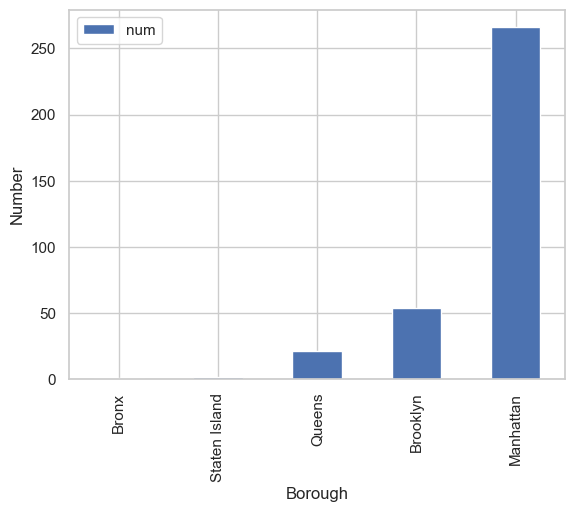

In [50]:
analyzer.num_french_restaurants_in_each_borough()

 ## Question: What are the cuisine types for the most expensive zipcode in New York?

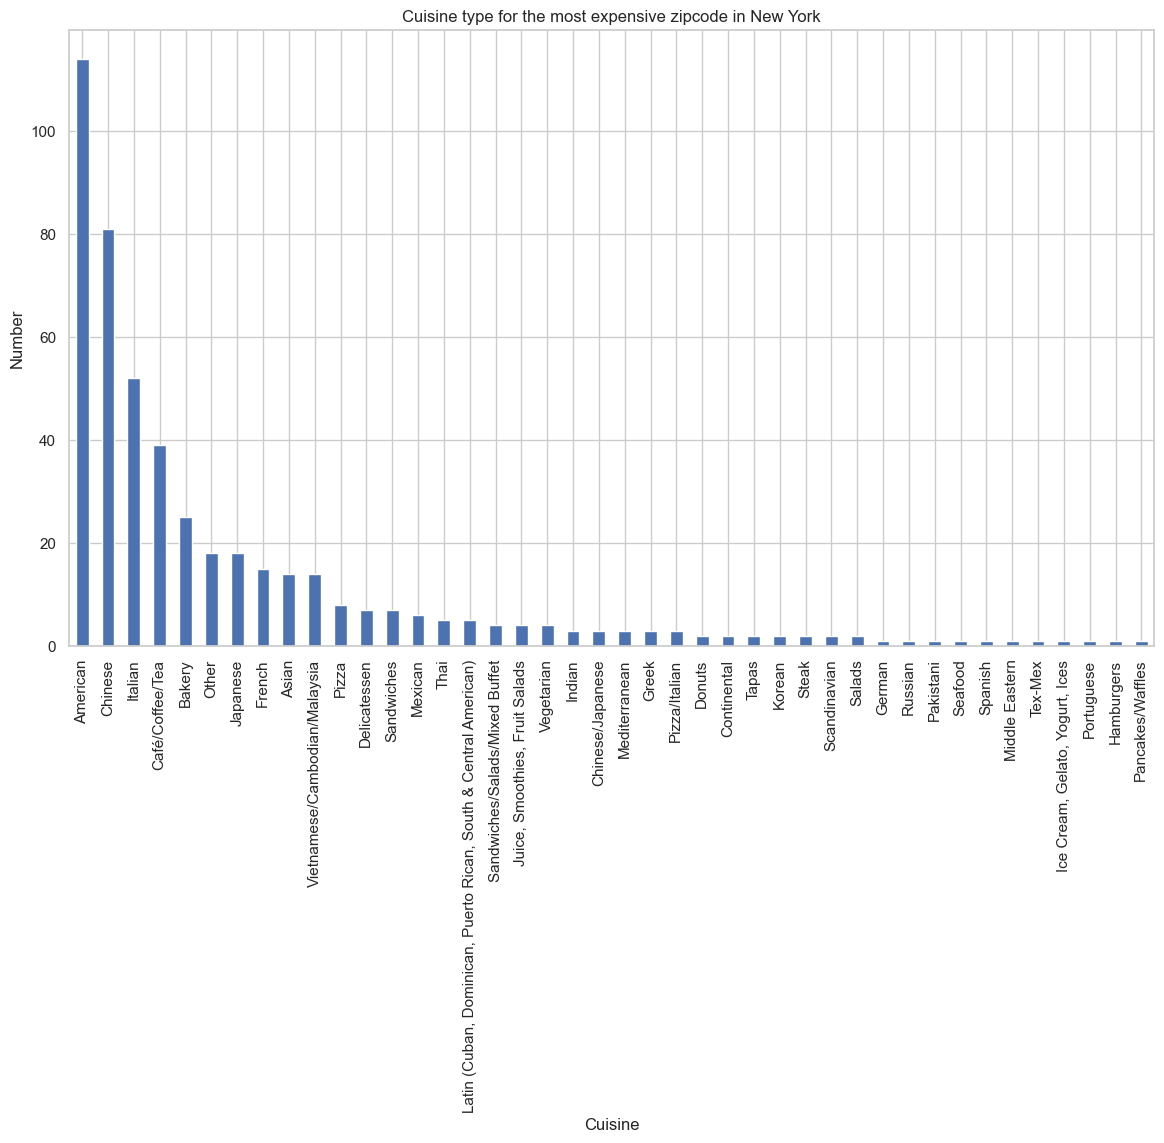

In [51]:
analyzer.expensive_restaurants()

## Question: What are the nearest restaurants to the empire state building?

In [52]:
analyzer.geonear_empire_state_building()

Name: Subway
Distance: 58.89021756756565
Address: West   35 Street, 2, 10001

Name: The Stellan
Distance: 58.89021756756565
Address: West 35 Street, 2, 10001

Name: Auntie Anne'S
Distance: 61.804812897660085
Address: West   34 Street, 19, 10001

Name: Potbelly Sandwich Shop
Distance: 70.33106336518857
Address: 5 Avenue, 366, 10001

Name: Paul'S Restaurant
Distance: 88.35325686625649
Address: West   34 Street, 22, 10001

Name: Sbarro
Distance: 88.35325686625649
Address: West   34 Street, 22, 10001

Name: Zoni Cafe
Distance: 88.35325686625649
Address: W 34Th St, 22, 10001

Name: Cafe Rustico Ii
Distance: 96.85942332761533
Address: West   35 Street, 25, 10018

Name: Lena
Distance: 98.4496673739068
Address: West   35 Street, 34, 10001

Name: Foley'S N.Y. Pub And Restaurant
Distance: 100.4221351114134
Address: West   33 Street, 18, 10001



[{'_id': ObjectId('65cbf1381ca270b18247500a'),
  'address': {'building': '2',
   'coord': [-73.98505639999999, 40.7492649],
   'street': 'West   35 Street',
   'zipcode': '10001'},
  'borough': 'Manhattan',
  'cuisine': 'Sandwiches',
  'grades': [{'date': datetime.datetime(2014, 8, 11, 0, 0),
    'grade': 'A',
    'score': 8},
   {'date': datetime.datetime(2013, 8, 26, 0, 0), 'grade': 'A', 'score': 9},
   {'date': datetime.datetime(2012, 9, 5, 0, 0), 'grade': 'A', 'score': 4},
   {'date': datetime.datetime(2012, 4, 16, 0, 0), 'grade': 'A', 'score': 9}],
  'name': 'Subway',
  'restaurant_id': '41120478',
  'distance': 58.89021756756565},
 {'_id': ObjectId('65cbf13a1ca270b1824779d3'),
  'address': {'building': '2',
   'coord': [-73.98505639999999, 40.7492649],
   'street': 'West 35 Street',
   'zipcode': '10001'},
  'borough': 'Manhattan',
  'cuisine': 'American',
  'grades': [{'date': datetime.datetime(2014, 8, 13, 0, 0),
    'grade': 'B',
    'score': 24},
   {'date': datetime.datetime